In [64]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from datatools import DataGrapher


%matplotlib inline

In [65]:
#Bring in the data

nba = pd.read_csv('./data/nba_analysis_data.csv')
nba.dropna(inplace = True)

In [66]:
#seperate test from train

nba_train = nba[nba.test == 0]
nba_test = nba[nba.test ==1]  #scott tarlow scotttarlow@gmail.com
#learn a domain

In [67]:
nba_train = nba_train[nba_train.playoff_game == 1]
nba_test = nba_test[nba_test.playoff_game == 1]

In [68]:

X_train = nba_train.drop(columns = ['cover','home_win_margin', 
                        'date', 'dataset','line_cv', 
                        'home_starter5', 'teams', 'away_team',
                        'away_starter2', 'away_starter3',
                        'away_starter4', 'away_starter5',
                        'ref_1', 'ref_3', 'crew_referees',
                        'away_pace', 'away_spread',
                        'away_line_cv',  'away_cover',
                        'home_payout', 'away_payout', 'over', 'under',
                        'total_score', 'total_diff'         ])


#X = nba[features]
y_train = nba_train['cover']

In [69]:
X_test= nba_test.drop(columns = ['cover','home_win_margin', 
                        'date', 'dataset','line_cv', 
                        'home_starter5', 'teams', 'away_team',
                        'away_starter2', 'away_starter3',
                        'away_starter4', 'away_starter5',
                        'ref_1', 'ref_3', 'crew_referees',
                        'away_pace', 'away_spread',
                        'away_line_cv',  'away_cover',
                        'home_payout', 'away_payout', 'over', 'under',
                        'total_score', 'total_diff'       ])

y_test = nba_test.away_cover

In [70]:

X_test.shape

(150, 150)

In [71]:
X_train.shape

(711, 150)

### Interaction Terms

At one point in the modeling process I hoped to get better results by including some interactions in the model.  They did not appear significant and added noise so they were removed, but I left the code in case I wanted to reinsert them later. 

In [72]:

# #create interactions  tested but did not help the model
# poly = PolynomialFeatures(degree = 2, interaction_only= True)
# X_poly = poly.fit_transform(X_train)
# X_poly_test = poly.transform(X_test)
# X_poly = pd.DataFrame(X_poly, 
#                       columns = poly.get_feature_names(X_train.columns))
# X_poly_test = pd.DataFrame(X_poly_test, 
#                            columns = poly.get_feature_names(X_test.columns))


### Scale and Transform the data

I use standard scaler scale the data and then do a principal components analysis to transform the data.  I do not care about inference in this case only prediction and there is a good deal of correlation between variables. So I decided to transform the data to reduce the number and get orthoginal features without losing much information.  I retain 99% of the variance.

In [73]:

#scaling data to use in various other methods
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [74]:
from sklearn.decomposition import PCA

In [75]:
pc = PCA(n_components=70)
X_train_pc = pc.fit_transform(X_train_scaled)
X_test_pc = pc.transform(X_test_scaled)


In [76]:
var_exp = pc.explained_variance_ratio_
print('Explained variance:            ', var_exp)

cum_var_exp = np.cumsum(var_exp)
print('Cumulative explained variance: ', cum_var_exp)

Explained variance:             [0.11779199 0.10546802 0.06201995 0.04434033 0.03990505 0.03690723
 0.03447765 0.03165107 0.03116379 0.02742084 0.02710235 0.02477437
 0.02341972 0.01969362 0.01891631 0.01764555 0.01653642 0.01566353
 0.0151614  0.01437477 0.01401727 0.01332526 0.0130128  0.01212139
 0.0116592  0.01065912 0.01006072 0.00983073 0.00920499 0.00871883
 0.00826443 0.00819963 0.00752512 0.007357   0.00712612 0.00678459
 0.00614287 0.00594805 0.00572655 0.00516833 0.00513162 0.00476264
 0.00456495 0.00415466 0.00399994 0.00388919 0.00365491 0.00340652
 0.00333786 0.00316325 0.00305489 0.00293599 0.00275122 0.00267653
 0.00252507 0.00238437 0.0022981  0.00206362 0.00199281 0.00195163
 0.0018501  0.00181444 0.00167024 0.00161227 0.00157333 0.00138521
 0.00136838 0.00134111 0.00125999 0.00115001]
Cumulative explained variance:  [0.11779199 0.22326    0.28527996 0.32962029 0.36952534 0.40643257
 0.44091022 0.47256129 0.50372507 0.53114592 0.55824826 0.58302263
 0.60644235 0.62613

### Logistic Regression

The first model I tested out was the logistic regression on good thing about the NBA data is that much of the data seemed to be normally distributed and my transformed features are uncorrelated so I thought

In [77]:
lr = LogisticRegressionCV(Cs = [100000],
                         max_iter=1000,
                         penalty = 'l1',
                         tol = .00001,
                         solver ='saga' )


lr.fit(X_train_pc, y_train)
print(lr.score(X_train_pc, y_train))


/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.6497890295358649


/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [78]:
lr.score(X_test_pc, y_test)

0.5533333333333333

In [79]:
y_hat_lr   = lr.predict(X_train_pc)
y_hat_lrp  = lr.predict_proba(X_train_pc)
y_hat_lrt  = lr.predict(X_test_pc)
y_hat_lrtp = lr.predict_proba(X_test_pc)

In [80]:
print(classification_report(y_train, y_hat_lr))

              precision    recall  f1-score   support

           0       0.63      0.60      0.62       333
           1       0.66      0.69      0.68       378

   micro avg       0.65      0.65      0.65       711
   macro avg       0.65      0.65      0.65       711
weighted avg       0.65      0.65      0.65       711



In [81]:
print(classification_report(y_test, y_hat_lrt))

              precision    recall  f1-score   support

           0       0.53      0.67      0.59        73
           1       0.59      0.44      0.50        77

   micro avg       0.55      0.55      0.55       150
   macro avg       0.56      0.56      0.55       150
weighted avg       0.56      0.55      0.55       150



In [82]:
confusion_matrix( y_train, y_hat_lr)

array([[200, 133],
       [116, 262]])

In [83]:
confusion_matrix( y_test, y_hat_lrt)

array([[49, 24],
       [43, 34]])

### Support Vector Machine

The second model I tested is the Support Vector Machine Model I 

In [84]:
svc = SVC(probability=True)
svc_params = {
    'kernel' : ['linear'  ], 
    'C'      : [.4, .2, .3]
    }

In [85]:
gs = GridSearchCV(svc, 
                  param_grid=svc_params, 
                  scoring='precision', 
                  cv = 5)
gs.fit(X_train_pc, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.5701839680524923
{'C': 0.2, 'kernel': 'linear'}


In [86]:
gs.score(X_test_pc, y_test)

0.576271186440678

In [87]:
#predict categories and  probabilities for svc model

y_hat_svc   = gs.predict(X_train_pc)
y_hat_svcp  = gs.predict_proba(X_train_pc)
y_hat_svct  = gs.predict(X_test_pc)
y_hat_svctp = gs.predict_proba(X_test_pc)

In [88]:
print(classification_report(y_train, y_hat_svc))

              precision    recall  f1-score   support

           0       0.65      0.61      0.63       333
           1       0.68      0.71      0.69       378

   micro avg       0.67      0.67      0.67       711
   macro avg       0.67      0.66      0.66       711
weighted avg       0.67      0.67      0.67       711



In [89]:
confusion_matrix( y_train, y_hat_svc)

array([[204, 129],
       [108, 270]])

In [90]:
confusion_matrix( y_test, y_hat_svct)

array([[48, 25],
       [43, 34]])

### Neural Network

In [91]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras import regularizers

In [92]:
model = Sequential()
model.add(Dense(70, 
                activation = 'relu',
                input_dim = X_train_pc.shape[1],
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.9))

#model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid')) #output layer 

In [93]:
model.compile(loss = 'binary_crossentropy', optimizer='adam',
              metrics = ['accuracy'])
model.fit(X_train_pc, 
          y_train, epochs =20, 
          batch_size= 128, 
          validation_data=(X_test_pc, y_test))

Train on 711 samples, validate on 150 samples
Epoch 1/20
711/711 [==============================] - 0s 488us/step - loss: 2.3811 - acc: 0.4866 - val_loss: 1.4858 - val_acc: 0.4933
Epoch 2/20
711/711 [==============================] - 0s 21us/step - loss: 2.2267 - acc: 0.4937 - val_loss: 1.4632 - val_acc: 0.5000
Epoch 3/20
711/711 [==============================] - 0s 22us/step - loss: 2.2605 - acc: 0.5148 - val_loss: 1.4395 - val_acc: 0.5000
Epoch 4/20
711/711 [==============================] - 0s 22us/step - loss: 2.1037 - acc: 0.5120 - val_loss: 1.4167 - val_acc: 0.4800
Epoch 5/20
711/711 [==============================] - 0s 21us/step - loss: 2.0761 - acc: 0.5190 - val_loss: 1.3962 - val_acc: 0.4933
Epoch 6/20
711/711 [==============================] - 0s 21us/step - loss: 1.9276 - acc: 0.5120 - val_loss: 1.3768 - val_acc: 0.5000
Epoch 7/20
711/711 [==============================] - 0s 22us/step - loss: 1.9252 - acc: 0.5134 - val_loss: 1.3589 - val_acc: 0.5067
Epoch 8/20
711/711 [==

In [94]:
#returns a probability

y_hat_nnp = model.predict(X_train_pc)
y_hat_nntp = model.predict(X_test_pc)


In [95]:
rf = RandomForestClassifier()
rf_params = {'n_estimators'      : [200],
             'max_depth'         : [80],
             'min_samples_split' : [200]}

gs = GridSearchCV(rf, 
                  param_grid=rf_params,
                  scoring='precision',
                 cv =5)
gs.fit(X_train_pc, y_train)
print(gs.best_score_)
print(gs.best_params_)



0.5343302704958972
{'max_depth': 80, 'min_samples_split': 200, 'n_estimators': 200}


In [96]:
gs.score(X_test_pc, y_test)

0.5045871559633027

In [97]:
y_hat_rf   = gs.predict(X_train_pc)
y_hat_rfp  = gs.predict_proba(X_train_pc)
y_hat_rft  = gs.predict(X_test_pc)
y_hat_rftp = gs.predict_proba(X_test_pc)

In [98]:
print(classification_report(y_train, y_hat_rf))

              precision    recall  f1-score   support

           0       0.94      0.42      0.58       333
           1       0.66      0.98      0.79       378

   micro avg       0.72      0.72      0.72       711
   macro avg       0.80      0.70      0.68       711
weighted avg       0.79      0.72      0.69       711



In [99]:
print(classification_report(y_test, y_hat_rft))

              precision    recall  f1-score   support

           0       0.46      0.26      0.33        73
           1       0.50      0.71      0.59        77

   micro avg       0.49      0.49      0.49       150
   macro avg       0.48      0.49      0.46       150
weighted avg       0.48      0.49      0.47       150



In [100]:
confusion_matrix( y_train, y_hat_rf)

array([[141, 192],
       [  9, 369]])

In [101]:
confusion_matrix( y_test, y_hat_rft)

array([[19, 54],
       [22, 55]])

In [102]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb_params = {'n_estimators'  : [140,150],
              'learning_rate' : [ .55,.5]}

gs = GridSearchCV(xgb, param_grid=xgb_params, cv =3)
gs.fit(X_train_pc, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.5428973277074542
{'learning_rate': 0.55, 'n_estimators': 140}


In [103]:
gs.score(X_test_pc, y_test)

0.49333333333333335

In [104]:
y_hat_xg   = gs.predict(X_train_pc)
y_hat_xgp  = gs.predict_proba(X_train_pc)
y_hat_xgt  = gs.predict(X_test_pc)
y_hat_xgtp = gs.predict_proba(X_test_pc)

In [105]:
confusion_matrix( y_train, y_hat_xg)

array([[333,   0],
       [  0, 378]])

In [106]:
confusion_matrix( y_test, y_hat_xgt)

array([[38, 35],
       [41, 36]])

In [107]:
#modifying train and testing data to allow for changing prob thresholds and printing the 
#roc curves 
#Random Forest
nba_train.loc[:, 'actual_y'] = y_train
nba_train.loc[:, 'predicted_label_rf'] = y_hat_rf
nba_train.loc[:, 'predicted_proba_rfp'] = y_hat_rfp[:, 1]

#SVC

nba_train.loc[:, 'predicted_label_svc'] = y_hat_svc
nba_train.loc[:, 'predicted_proba_svcp'] = y_hat_svcp[:, 1]

#Logistic
nba_train.loc[:, 'predicted_label_lr'] = y_hat_lr
nba_train.loc[:, 'predicted_proba_lrp'] = y_hat_lrp[:, 1]

#XGBOOST
nba_train.loc[:, 'predicted_label_xg'] = y_hat_xg
nba_train.loc[:, 'predicted_proba_xgp'] = y_hat_xgp[:, 1]


In [150]:
#Random Forest
nba_test.loc[:, 'actual_y'] = y_test
nba_test.loc[:, 'predicted_label_rf'] = y_hat_rft
nba_test.loc[:, 'predicted_proba_rfp'] = y_hat_rftp[:, 1]

#SVC

nba_test.loc[:, 'predicted_label_svc'] = y_hat_svct
nba_test.loc[:, 'predicted_proba_svcp'] = y_hat_svctp[:, 1]

#Logistic
nba_test.loc[:, 'predicted_label_lr'] = y_hat_lrt
nba_test.loc[:, 'predicted_proba_lrp'] = y_hat_lrtp[:, 1]

#XGBOOST
nba_test.loc[:, 'predicted_label_xg'] = y_hat_xgt
nba_test.loc[:, 'predicted_proba_xgp'] = y_hat_xgtp[:, 1]

#Neural Network
nba_test.loc[:, 'predicted_proba_nnp'] = y_hat_nntp
nba_test.loc[:, 'predicted_label_nn'] = nba_test.predicted_proba_nnp.map(
                lambda x: 0 if x<=.5 else 1)

#Combined 
nba_test['vote'] = (nba_test.predicted_label_lr +
                nba_test.predicted_label_rf +
                nba_test.predicted_label_svc +
                nba_test.predicted_label_xg +
                nba_test.predicted_label_nn
                )




In [151]:
confusion_matrix(y_test, nba_test.combined_actual)

array([[32, 41],
       [37, 40]])

In [152]:
nba_test.vote.value_counts(normalize = True)

5    0.213333
3    0.206667
2    0.206667
1    0.166667
4    0.106667
0    0.100000
Name: vote, dtype: float64

In [153]:
nba_test.groupby(['vote'])['actual_y'].mean()

vote
0    0.466667
1    0.560000
2    0.483871
3    0.419355
4    0.687500
5    0.531250
Name: actual_y, dtype: float64

In [111]:
from sklearn.metrics import roc_curve, auc

In [112]:
fpr, tpr, _ = roc_curve(y_train, nba_train['predicted_proba_svcp'])
roc_auc = auc(fpr, tpr)

In [113]:
fpr1, tpr1, _ = roc_curve(y_test, nba_test['predicted_proba_svcp'])
roc_auc1 = auc(fpr1, tpr1)

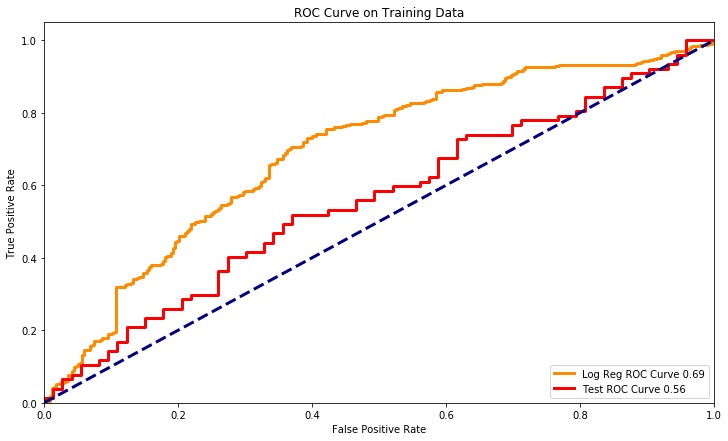

In [114]:
# Plot 
plt.figure(figsize = (12,7))
line_width = 3

plt.plot(fpr, tpr, lw = line_width, color="darkorange", 
         label = "Log Reg ROC Curve %.2f" % roc_auc)
plt.plot(fpr1, tpr1, lw = line_width, color="red", 
         label = "Test ROC Curve %.2f" % roc_auc1)
plt.plot([0,1], [0, 1], lw = line_width, linestyle="--", color="navy")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Training Data')
plt.legend(loc="lower right")
plt.show()

In [115]:
for prob in range(40, 65, 1):
    proba = prob/100
    
    nba_train.loc[:, 'predicted_label']= nba_train['predicted_proba_rfp'].map(
    lambda p: 1 if p > proba else 0)
    
    nba_test.loc[:, 'predicted_label']= nba_test['predicted_proba_rfp'].map(
    lambda p: 1 if p > proba else 0)
    
#     X_train.loc[:, 'predicted_label']= X_train['predicted_proba_rfp'].map(
#     lambda p: 1 if p > proba else 0)
    
#    results = X_test[X_test['predicted_label']==1]
    print('Test  ' + str(proba))
#     print (confusion_matrix(y_test, nba['predicted_label']))
    results_neg = nba_train[nba_train['predicted_label']==1]
    print ("Return of Home Games: ", results_neg.home_payout.sum())
#     print(' Train  ' + str(proba))
#     print(confusion_matrix(y_train, X_train['predicted_label']))

Test  0.4
Return of Home Games:  24.60199999999999
Test  0.41
Return of Home Games:  24.60199999999999
Test  0.42
Return of Home Games:  24.60199999999999
Test  0.43
Return of Home Games:  25.60199999999999
Test  0.44
Return of Home Games:  25.60199999999999
Test  0.45
Return of Home Games:  31.601999999999983
Test  0.46
Return of Home Games:  40.60199999999999
Test  0.47
Return of Home Games:  58.69299999999999
Test  0.48
Return of Home Games:  79.69299999999998
Test  0.49
Return of Home Games:  117.78399999999999
Test  0.5
Return of Home Games:  152.421
Test  0.51
Return of Home Games:  192.42200000000003
Test  0.52
Return of Home Games:  222.969
Test  0.53
Return of Home Games:  221.063
Test  0.54
Return of Home Games:  211.42999999999998
Test  0.55
Return of Home Games:  179.16200000000006
Test  0.56
Return of Home Games:  142.803
Test  0.57
Return of Home Games:  113.16999999999999
Test  0.58
Return of Home Games:  71.72000000000001
Test  0.59
Return of Home Games:  39.90499999999

In [116]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.feature_importances_

feature_scores = pd.DataFrame(rf.feature_importances_,
                            index = X_train.columns,
                            columns=['Feature Scores']).sort_values(
                            'Feature Scores',ascending=False)

feature_scores

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,Feature Scores
lastaway_assists,0.026854
mov_5_away_turnovers,0.020922
mov_5_away_def_eff,0.017220
moneyline,0.016953
mov_5_away_3p,0.016451
lastaway_off_eff,0.016122
mov_5_line_cv,0.016009
eff_ratio4,0.015970
lastaway_pace,0.015522
lastaway_fta,0.015236


In [117]:
rf.score(X_train, y_train)

0.9845288326300985

In [118]:
rf.score(X_test, y_test)

0.5